In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_squared_error
from feature_engine.outliers import Winsorizer
import category_encoders as ce

In [4]:
df = pd.read_csv('Projeto_1_ML.csv')
df.head()

,age,work_industry,job_title,annual_salary,currency,country,state_(US),city,overall_work_exp.,fieldwork _exp.,level_of_education,gender,race
0,25-34,Education,Research and Instruction Librarian,55000.0,USD,USA,Massachusetts,Boston,5 - 7 years,5 - 7 years,Master's degree,Woman,White
1,25-34,Accounting/Banking/Finance,Marketing Specialist,34000.0,USD,USA,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
2,25-34,Nonprofits,Program Manager,62000.0,USD,USA,Wisconsin,Milwaukee,8 - 10 years,5 - 7 years,College degree,Woman,White
3,25-34,Accounting/Banking/Finance,Accounting Manager,60000.0,USD,USA,South Carolina,Greenville,8 - 10 years,5 - 7 years,College degree,Woman,White
4,25-34,Education,Scholarly Publishing Librarian,62000.0,USD,USA,New Hampshire,Hanover,8 - 10 years,2 - 4 years,Master's degree,Man,White


### Análise de Valores Missing

In [5]:
#Porcentagem de valores nulos por variável.

df.isnull().mean().mul(100).round(2)

age                   0.00
work_industry         0.24
job_title             0.00
annual_salary         0.00
currency              0.00
country               0.00
state_(US)            0.71
city                  0.25
overall_work_exp.     0.00
fieldwork _exp.       0.00
level_of_education    0.51
gender                0.41
race                  0.00
dtype: float64

In [6]:
#Porcentagem de valores nulos em todo o conjunto de dados.
df.isnull().mean().mul(100).sum().round(2)

2.11

In [7]:
#Percebe-se que a porcentagem de valores nulos é muito pequena. Supondo que cada valor nulo de cada coluna seja correspondente a
# a uma entrada de dado diferente, ainda assim a porcentagem de entradas que possuem valores nulos seria muito pequena (3,06%)
#Com isso, eliminarei as entradas de dados com valores nulos.

df.dropna(inplace=True)
df.isnull().mean().mul(100).sum().round(2)

0.0

### Escolha das variáveis

- Conforme explicado anteriormente, visto que limitamos a análise àquelas pessoas que ganham em dólar e residem nos Estados Unidos, descartaremos essas duas variáveis ("country" e "currency") por se tornarem irrelevantes. 


- Conforme visto anteriormente, a variável "city" possui uma cardinalidade grande: As subdivisões administrativas dos Estados Unidos são variadas. Diferentemente do Brasil, não há apenas municípios/cidades. Dentro as categorias dessa variável estavam inclusos condados, distritos além das cidades em si. Seria bastante complicado realizar o tratamento completo dessa coluna. Com isso, a mesma foi descartada do modelo para que este represente algo mais consistente. 

- A variável "job_title" possui uma cardinalidade imensa e completa falta de padrão no preenchimento (assim como todo o Data Set em sua grande maioria) e portanto foi completamente descartada do modelo. É importante frisar que ao considerar essa variável no modelo, o mesmo obteve um melhor desempenho. Contudo, há de se considerar que apesar disso o modelo se tornaria inconsistente, visto que, nesse caso, o dados que o alimentam não possuem um padrão de preenchimento, se tornando ambíguos, "poluídos", sem confiança. 

In [8]:
df['job_title'].value_counts(normalize=True).mul(100)

Software Engineer                 1.016025
Project Manager                   0.794347
Senior Software Engineer          0.734309
Director                          0.725073
Program Manager                   0.604997
                                    ...   
Pathology Admin Coordinator       0.004618
Editor at news outlet             0.004618
Business Process Manager          0.004618
Community Engagement Associate    0.004618
senior wifi engineer              0.004618
Name: job_title, Length: 11413, dtype: float64

In [9]:
df['job_title'].nunique()

11413

- Visto que a variável 'job_title' poderia ser muito importante para o modelo, descartar também a variável 'work_industry' provocaria muita perda de informação. Com isso, apesar da grande cardinalidade, tentou-se realizar um tratamento minimamente satisfatório. Buscou-se tratar as 20 categorias com maior número (elas representaram 95,5% dos dados), removendo ambiguidade e agrupando de forma mais lógica as categorias. As categorias restantes foram agrupadas em uma nova categoria chamada 'Others/Not Correctly Specified'.  


- Conforme explicado anteriormente, a variável "state_(US)" possui como um dos seus valores o valor "More than one State" e a capital do país, Washington D.C (distrito), considerada como estado para fins dessa análise. Está identificada como "District of Columbia".

In [10]:
X = df.drop(['annual_salary', 'job_title', 'currency', 'country', 'city'], axis=1)
y = df['annual_salary']
df = pd.concat([X, y], axis=1)
df.head()

,age,work_industry,state_(US),overall_work_exp.,fieldwork _exp.,level_of_education,gender,race,annual_salary
0,25-34,Education,Massachusetts,5 - 7 years,5 - 7 years,Master's degree,Woman,White,55000.0
1,25-34,Accounting/Banking/Finance,Tennessee,2 - 4 years,2 - 4 years,College degree,Woman,White,34000.0
2,25-34,Nonprofits,Wisconsin,8 - 10 years,5 - 7 years,College degree,Woman,White,62000.0
3,25-34,Accounting/Banking/Finance,South Carolina,8 - 10 years,5 - 7 years,College degree,Woman,White,60000.0
4,25-34,Education,New Hampshire,8 - 10 years,2 - 4 years,Master's degree,Man,White,62000.0


### Separação do conjunto de dados
  > Realizar essa separação de imediato (antes das transformações nos dados) é crucial para **evitar** ***Data Leakage***.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 4)

### Target

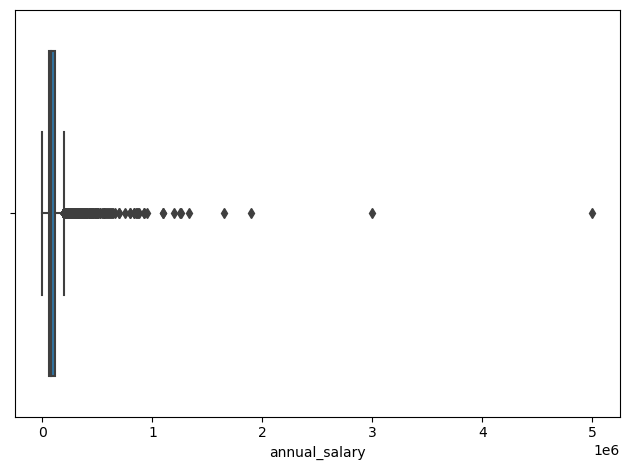

In [12]:
sns.boxplot(x=df['annual_salary'])
plt.tight_layout()

In [13]:
#Removendo "outliers": Importante frisar que a maneira como a pesquisa foi feita não garante segurança alguma nas respostas
#aumentando ainda mais a chance dos valores serem inverídicos e portanto serem de fato um outlier. Escolhi a abordagem mais
#conservadora considerando o intervalo inter-quartil pois o conjunto de dados é muito poluído e só dessa forma teremos um modelo
#com mínima capacidade preditiva. 

outlier = Winsorizer(
    variables= ['annual_salary'],
    capping_method= 'iqr',
    tail= 'both',                          
    fold= 1.5
                    )

#Esse transformador só aceita DataFrames. Por isso tive que fazer a conversão.
y_train_winsorized= outlier.fit_transform(y_train.to_frame())
y_test_winsorized= outlier.transform(y_test.to_frame())

#Agora estou convertendo de volta para Série.
y_train_winsorized = y_train_winsorized.squeeze()
y_test_winsorized = y_test_winsorized.squeeze()

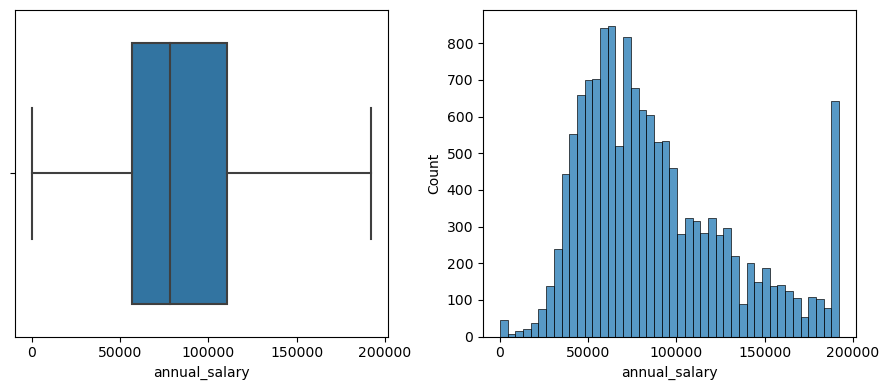

In [14]:
fig, ax = plt.subplots(1,2, figsize= (9,4))

sns.boxplot(x= y_train_winsorized, ax= ax[0])
sns.histplot(x= y_train_winsorized, ax= ax[1])

plt.tight_layout()

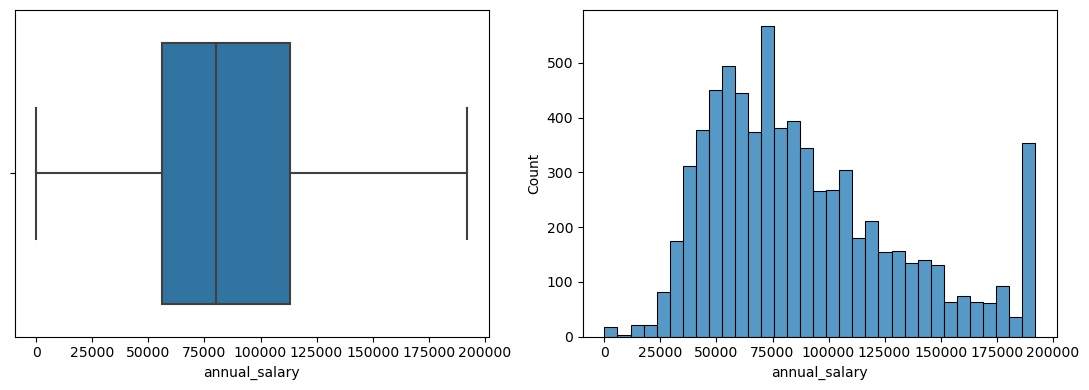

In [15]:
fig, ax = plt.subplots(1,2, figsize= (11,4))

sns.boxplot(x= y_test_winsorized, ax= ax[0])
sns.histplot(x= y_test_winsorized, ax= ax[1])

plt.tight_layout()

## Machine Learning

### Pré-processamento

In [16]:
X_train.columns

Index(['age', 'work_industry', 'state_(US)', 'overall_work_exp.',
       'fieldwork _exp.', 'level_of_education', 'gender', 'race'],
      dtype='object')

In [17]:
X_train.shape

(14507, 8)

#### Features

- Foi escolhido ***HelmertEncoder*** pois o mesmo considera a ordenação da variável e suas classes de ordenação. Para estabelecer o encoding leva em consideração todos os níveis da respectiva classe. Dessa forma o valor numérico atribuído a cada categoria tende a ser mais realista pois leva em consideração o conjunto de classes/níveis de cada variável. 


- Foi escolhido o ***LeaveOneOutEncoder*** pois visto que o modelo está tendendo underfitar, encodigns Bayesianos são bem vindos. Essa classe de encodings tem como tendência overfitar pois coletam informações da variável target para estabelcer o valor númerico de suas categorias. No caso do LOOE utiliza-se o valor esperado, desconsiderando a respectiva instância (por isso *leave-one-out*). Para esse Data Set foi a melhor escolha pois ao fazer essa manobra diminui o impacto de outliers.

In [18]:
features_pipe = make_column_transformer(
    (ce.HelmertEncoder(handle_unknown='ignore'), ['level_of_education', 'overall_work_exp.', 'fieldwork _exp.']),
    (ce.LeaveOneOutEncoder(handle_unknown='ignore'), ['state_(US)', 'work_industry', 'gender', 'race', 'age']))

### Cross-Validation

#### TransformedTargetRegressor

In [19]:
#Com transformação da variável target:

ttr = TransformedTargetRegressor(
                            regressor = LinearRegression(),
                            transformer = PowerTransformer()
                                )

final_pipe = Pipeline([('features_pipe', features_pipe), ('model', ttr)])

cv_ttr = cross_validate(final_pipe, X_train, y_train_winsorized, cv = 10, 
                        scoring = ('r2', 'neg_root_mean_squared_error'), n_jobs = -1, return_train_score= True)

cv_ttr_df = pd.DataFrame(cv_ttr)
cv_ttr_df[['train_neg_root_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_r2', 'test_r2']].mean()

train_neg_root_mean_squared_error   -32350.734420
test_neg_root_mean_squared_error    -32546.135971
train_r2                                 0.418873
test_r2                                  0.410900
dtype: float64

In [20]:
#Utilizando o conjunto de dados de teste para simular dados em produção:

final_pipe.fit(X_train, y_train_winsorized)
y_pred = final_pipe.predict(X_test)

r2_det_test_cv_ttr = r2_score(y_test_winsorized, y_pred)
rmse_test_cv_ttr = mean_squared_error(y_test_winsorized, y_pred, squared = False)

print('O Coeficiente de Determinação com novos dados é:', r2_det_test_cv_ttr.round(3))
print('O RMSE com novos dados é:', rmse_test_cv_ttr.round(3))

O Coeficiente de Determinação com novos dados é: 0.432
O RMSE com novos dados é: 32346.791


#### LinearRegression

In [21]:
#Sem transformação da variável target:

lr = LinearRegression()

final_pipe = Pipeline([('features_pipe', features_pipe), ('model', lr)])

cv_lr = cross_validate(final_pipe, X_train, y_train_winsorized, cv = 10, 
                       scoring = ('r2', 'neg_root_mean_squared_error'), n_jobs = -1, return_train_score= True)

cv_lr_df = pd.DataFrame(cv_lr)
cv_lr_df[['train_neg_root_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_r2', 'test_r2']].mean()

train_neg_root_mean_squared_error   -32299.139495
test_neg_root_mean_squared_error    -32497.322178
train_r2                                 0.420725
test_r2                                  0.412638
dtype: float64

In [22]:
#Utilizando o conjunto de dados de teste para simular dados em produção:

final_pipe.fit(X_train, y_train_winsorized)
y_pred = final_pipe.predict(X_test)

r2_test_cv_lr = r2_score(y_test_winsorized, y_pred)
rmse_test_cv_lr = mean_squared_error(y_test_winsorized, y_pred, squared = False)

print('O Coeficiente de Determinação com novos dados é:', r2_test_cv_lr.round(3))
print('O RMSE com novos dados é:', rmse_test_cv_lr.round(3))

O Coeficiente de Determinação com novos dados é: 0.439
O RMSE com novos dados é: 32148.283


#### AdaBoostRegressor

In [59]:
ab_lr = AdaBoostRegressor(lr, n_estimators= 100, random_state= 20, learning_rate=5)

final_pipe = Pipeline([('features_pipe', features_pipe), ('model', ab_lr)])

cv_ab_lr =  cross_validate(final_pipe, X_train, y_train_winsorized, cv = 10, n_jobs= -1, 
                           scoring = ('r2', 'neg_root_mean_squared_error'), return_train_score= True)

cv_ab_lr_df = pd.DataFrame(cv_ab_lr)
cv_ab_lr_df[['train_neg_root_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_r2', 'test_r2']].mean()

train_neg_root_mean_squared_error   -32329.068136
test_neg_root_mean_squared_error    -32541.235742
train_r2                                 0.419652
test_r2                                  0.411026
dtype: float64

In [60]:
#Utilizando o conjunto de dados de teste para simular dados em produção:

final_pipe.fit(X_train, y_train_winsorized)

y_pred = final_pipe.predict(X_test)

r2_test_cv_ab_lr = r2_score(y_test_winsorized, y_pred)
rmse_test_cv_ab_lr = mean_squared_error(y_test_winsorized, y_pred, squared = False)

print('O Coeficiente de Determinação com novos dados é:', r2_test_cv_ab_lr.round(3))
print('O RMSE com novos dados é:', rmse_test_cv_ab_lr.round(3))

O Coeficiente de Determinação com novos dados é: 0.438
O RMSE com novos dados é: 32190.301


#### GradientBoostingRegressor

In [23]:
gbr = GradientBoostingRegressor(max_depth=10, n_estimators=100, random_state=4, learning_rate=0.031)

final_pipe = Pipeline([('features_pipe', features_pipe), ('model', gbr)])

cv_gbr =  cross_validate(final_pipe, X_train, y_train_winsorized, cv = 10, n_jobs= -1, 
                           scoring = ('r2', 'neg_root_mean_squared_error'), return_train_score= True)

cv_gbr_df = pd.DataFrame(cv_gbr)
cv_gbr_df[['train_neg_root_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_r2', 'test_r2']].mean()

train_neg_root_mean_squared_error   -41728.310442
test_neg_root_mean_squared_error    -41766.274716
train_r2                                 0.033080
test_r2                                  0.030498
dtype: float64

In [24]:
#Utilizando o conjunto de dados de teste para simular dados em produção:

final_pipe.fit(X_train, y_train_winsorized)

y_pred = final_pipe.predict(X_test)

r2_test_cv_gbr = r2_score(y_test_winsorized, y_pred)
rmse_test_cv_gbr = mean_squared_error(y_test_winsorized, y_pred, squared = False)

print('O Coeficiente de Determinação com novos dados é:', r2_test_cv_gbr.round(3))
print('O RMSE com novos dados é:', rmse_test_cv_gbr.round(3))

O Coeficiente de Determinação com novos dados é: 0.044
O RMSE com novos dados é: 41960.286


#### Random Forest 

In [25]:
rf = RandomForestRegressor(n_estimators =100, n_jobs=-1, random_state=2)

final_pipe = Pipeline([('features_pipe', features_pipe), ('model', rf)])

param_grid = {'model__max_depth': np.arange(8, 19)}

rcv_rf = RandomizedSearchCV(final_pipe, param_grid, n_jobs= -1, cv= 10, return_train_score= True,
                scoring= ['neg_root_mean_squared_error', 'r2'], refit= 'neg_root_mean_squared_error')
 
rcv_rf.fit(X_train, y_train_winsorized)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('features_pipe',
                                              ColumnTransformer(transformers=[('helmertencoder',
                                                                               HelmertEncoder(handle_unknown='ignore'),
                                                                               ['Level '
                                                                                'of '
                                                                                'Education',
                                                                                'Overall '
                                                                                'Work '
                                                                                'Exp.',
                                                                                'Fieldwork '
                                                                  

In [31]:
rcv_rf_df = pd.DataFrame(rcv_rf.cv_results_)
(rcv_rf_df[['params', 'mean_train_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'mean_train_r2', 'mean_test_r2']]
                                                .sort_values('mean_test_neg_root_mean_squared_error', ascending= False).round(2))

,params,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2
0,{'model__max_depth': 15},-41662.36,-41658.12,0.04,0.04
5,{'model__max_depth': 12},-41658.64,-41660.92,0.04,0.04
1,{'model__max_depth': 13},-41660.83,-41661.95,0.04,0.04
8,{'model__max_depth': 14},-41663.10,-41662.14,0.04,0.04
3,{'model__max_depth': 11},-41664.62,-41667.20,0.04,0.04
7,{'model__max_depth': 16},-41669.50,-41668.16,0.04,0.04
2,{'model__max_depth': 17},-41669.79,-41671.26,0.04,0.04
4,{'model__max_depth': 18},-41672.45,-41671.74,0.04,0.04
9,{'model__max_depth': 10},-41703.63,-41704.05,0.03,0.03
6,{'model__max_depth': 9},-41919.25,-41927.36,0.02,0.02


In [33]:
#Utilizando o conjunto de dados de teste para simular dados em produção:

rcv_rf.best_estimator_.fit(X_train, y_train_winsorized)
y_pred =  rcv_rf.best_estimator_.predict(X_test)

r2_test_cv_rf = r2_score(y_test_winsorized, y_pred)
rmse_test_cv_rf = mean_squared_error(y_test_winsorized,y_pred, squared= False)

print('O Coeficiente de Determinação com novos dados é:', r2_test_cv_rf.round(3))
print('O RMSE com novos dados é:', rmse_test_cv_rf.round(3))

O Coeficiente de Determinação com novos dados é: 0.036
O RMSE com novos dados é: 42155.173


### Considerações Finais

##### Dentre os modelos testados o que melhor performou foi a Regressão Linear. Contudo, é importante frisar que ainda assim não se tem um preditor muito confiável pois o seu RMSE é relativamente alto. Conforme se pode observar abaixo, o erro médio quadrático representa aproximadamente 35% da média de salário anual. Se analisarmos a mediana, temos ume representação de 40% do valor do salário anual. 

In [26]:
mean_error_percentage = round(rmse_test_cv_lr.round(3) / round(y_test_winsorized.mean(), 3), 2)*100
median_error_percentage = round(rmse_test_cv_lr.round(3) / round(y_test_winsorized.median(), 3), 2)*100

mean_error_percentage, median_error_percentage

(36.0, 40.0)

##### Era de se esperar que isso acontecesse visto que temos um conjunto de dados muito poluído, sem nenhum padrão de inputação. Completamente arbitrário. Sujeito a entrada de dados falsos, inclusive. Além disso, a variável job_title, muito boa preditora, não foi usada, diminuindo a precisão do modelo. Há de se considerar também o viés da pesquisa. O site responsável por realizá-la pode ser mais acessado por um nicho específico de pessoas, seja no que tange à localização geográfica como também ao nível social, costumes, faixa etária. E isso de fato pode ser em parte percebido pelos gráficos de barra de algumas variáveis. Portanto, a ausência de uma amostragem estratificada introduz um viés muito forte na pesquisa, diminuindo ainda mais a confiança que se pode ter no modelo.

 - Importante salientar que o coeficiente de determinação foi mostrado para mostrar a "confiabilidade estatística" do modelo, não sendo considerado como de fato uma métrica prática no que tange à sua capacidade preditiva. Por isso apenas o RMSE foi mensionado nas considerações finais. 